In [3]:
# Download all the necessay libraries
library(tidyverse)
library(repr)
library(tidymodels)
options(repr.matrix.max.rows = 6)
source("tests.R")
source("cleanup.R")

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.1 ──

✔ ggplot2 3.3.6     ✔ purrr   0.3.4
✔ tibble  3.1.7     ✔ dplyr   1.0.9
✔ tidyr   1.2.0     ✔ stringr 1.4.0
✔ readr   2.1.2     ✔ forcats 0.5.1

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

── Attaching packages ────────────────────────────────────── tidymodels 1.0.0 ──

✔ broom        1.0.0     ✔ rsample      1.0.0
✔ dials        1.0.0     ✔ tune         1.0.0
✔ infer        1.0.2     ✔ workflows    1.0.0
✔ modeldata    1.0.0     ✔ workflowsets 1.0.0
✔ parsnip      1.0.0     ✔ yardstick    1.0.0
✔ recipes      1.0.1     

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales::discard() masks purrr::discard()
✖ dplyr::filter()   masks stats::filter()
✖ recipes::fixed()  masks stringr::fixed()
✖ dplyr::lag()      masks stats::lag()
✖ yardstick::spec() masks r

ERROR: Error in file(filename, "r", encoding = encoding): cannot open the connection


### Title of Project: Optimizing Dry Bean Sorting Efficiency with Automated Image Classification Techniques

In [4]:

# Read dataset

bean_data <- read_csv("project_data/Dry_Bean_Dataset.csv")|>
# convert the character Class variable to the factor datatype
mutate(Class = as_factor(Class)) 
bean_data

Rows: 13611 Columns: 17
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr  (1): Class
dbl (16): Area, Perimeter, MajorAxisLength, MinorAxisLength, AspectRation, E...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


Area,Perimeter,MajorAxisLength,MinorAxisLength,AspectRation,Eccentricity,ConvexArea,EquivDiameter,Extent,Solidity,roundness,Compactness,ShapeFactor1,ShapeFactor2,ShapeFactor3,ShapeFactor4,Class
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
28395,610.291,208.1781,173.8887,1.197191,0.5498122,28715,190.1411,0.7639225,0.9888560,0.9580271,0.9133578,0.007331506,0.003147289,0.8342224,0.9987239,SEKER
28734,638.018,200.5248,182.7344,1.097356,0.4117853,29172,191.2728,0.7839681,0.9849856,0.8870336,0.9538608,0.006978659,0.003563624,0.9098505,0.9984303,SEKER
29380,624.110,212.8261,175.9311,1.209713,0.5627273,29690,193.4109,0.7781132,0.9895588,0.9478495,0.9087742,0.007243912,0.003047733,0.8258706,0.9990661,SEKER
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
42139,759.321,281.5399,191.1880,1.472582,0.7340648,42569,231.6313,0.7299324,0.9898988,0.9184241,0.8227297,0.006681220,0.001888271,0.6768842,0.9967673,DERMASON
42147,763.779,283.3826,190.2757,1.489326,0.7410548,42667,231.6532,0.7053891,0.9878126,0.9079065,0.8174575,0.006723673,0.001852025,0.6682367,0.9952224,DERMASON
42159,772.237,295.1427,182.2047,1.619841,0.7866930,42600,231.6862,0.7889625,0.9896479,0.8883804,0.7849972,0.007000705,0.001639812,0.6162206,0.9981796,DERMASON


## Forward selection to determine best predictors

In [ ]:
# select all columns (possible predictors) except Class
names <- colnames(BeanData |> select (-Class))

# Make model formula for all predictors
model_formula <- paste("Class", "~", paste(names, collapse="+"))
model_formula 

# create an empty tibble to store the results
accuracies <- tibble(size = integer(), 
                     model_string = character(), 
                     accuracy = numeric())

# create a model specification
knn_spec <- nearest_neighbor(weight_func = "rectangular", 
                             neighbors = tune()) |>
     set_engine("kknn") |>
     set_mode("classification")

# create a 5-fold cross-validation object
BeanData_vfold <- vfold_cv(BeanData, v = 5, strata = Class)

# store the total number of predictors
n_total <- length(names)

# stores selected predictors
selected <- c()

In [ ]:

# for every size from 1 to the total number of predictors
for (i in 1:n_total) {
    # for every predictor still not added yet
    accs <- list()
    models <- list()
    for (j in 1:length(names)) {
        # create a model string for this combination of predictors
        preds_new <- c(selected, names[[j]])
        model_string <- paste("Class", "~", paste(preds_new, collapse="+"))

        # create a recipe from the model string
        BeanData_recipe <- recipe(as.formula(model_string), 
                                data = BeanData) |>
                          step_scale(all_predictors()) |>
                          step_center(all_predictors())

        # tune the KNN classifier with these predictors, 
        # and collect the accuracy for the best K
        acc <- workflow() |>
          add_recipe( BeanData_recipe ) |>
          add_model(knn_spec) |>
          tune_grid(resamples = BeanData_vfold, grid = 10) |>
          collect_metrics() |>
          filter(.metric == "accuracy") |>
          summarize(mx = max(mean))
        acc <- acc$mx |> unlist()

        # add this result to the dataframe
        accs[[j]] <- acc
        models[[j]] <- model_string
    }
    jstar <- which.max(unlist(accs))
    accuracies <- accuracies |> 
      add_row(size = i, 
              model_string = models[[jstar]], 
              accuracy = accs[[jstar]])
    selected <- c(selected, names[[jstar]])
    names <- names[-jstar]
}
accuracies


In [10]:
#Preliminary exploratory data analysis:
bean_count <- bean_data |>
                group_by(Class) |>
                summarise(count = n()) |>
                arrange(desc(count)) 
          

bean_count
visualization <- bean_count |>
ggplot(aes(x= count, fill = Class)) +
                geom_histogram(position = "identity") +
                facet_grid(rows = vars(count)) +
                binwidth = 30
visualization
# histograms visualize the distribution of one quantitative variable
# (i.e., all its possible values and how often they occur)


Class,count
<fct>,<int>
DERMASON,3546
SIRA,2636
SEKER,2027
⋮,⋮
CALI,1630
BARBUNYA,1322
BOMBAY,522


ERROR: Error in visualization <- ggplot(bean_count, aes(x = count, fill = Class)) + : object 'visualization' not found


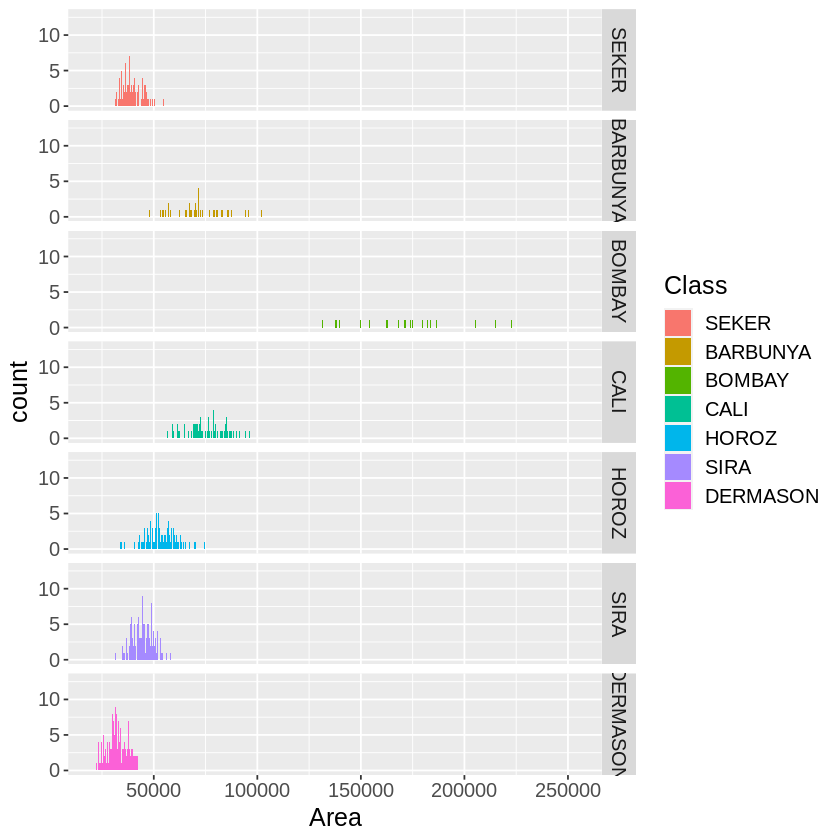

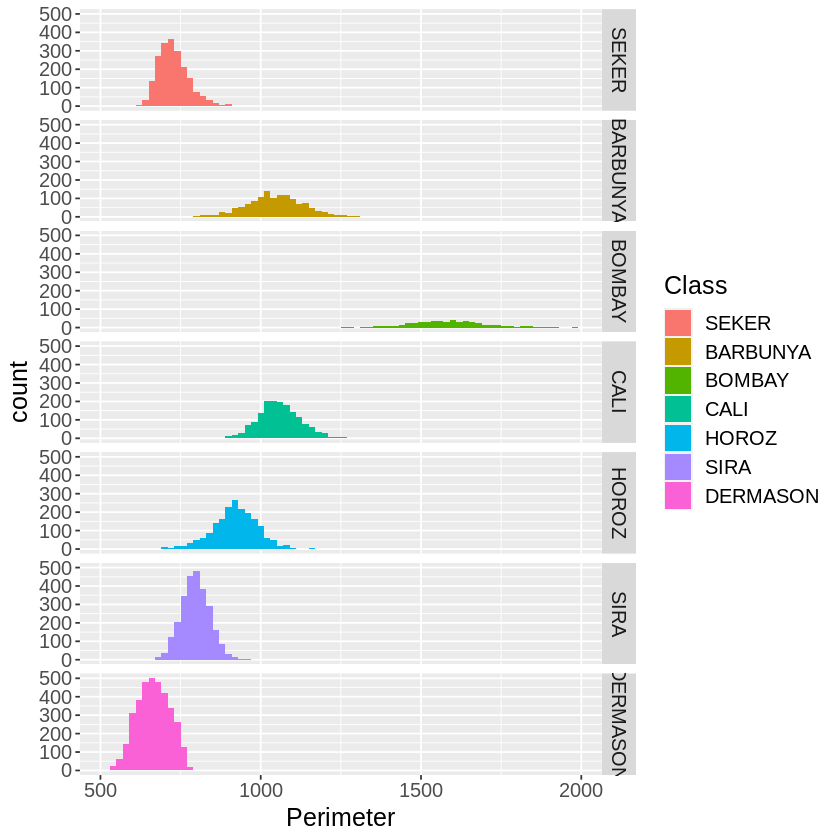

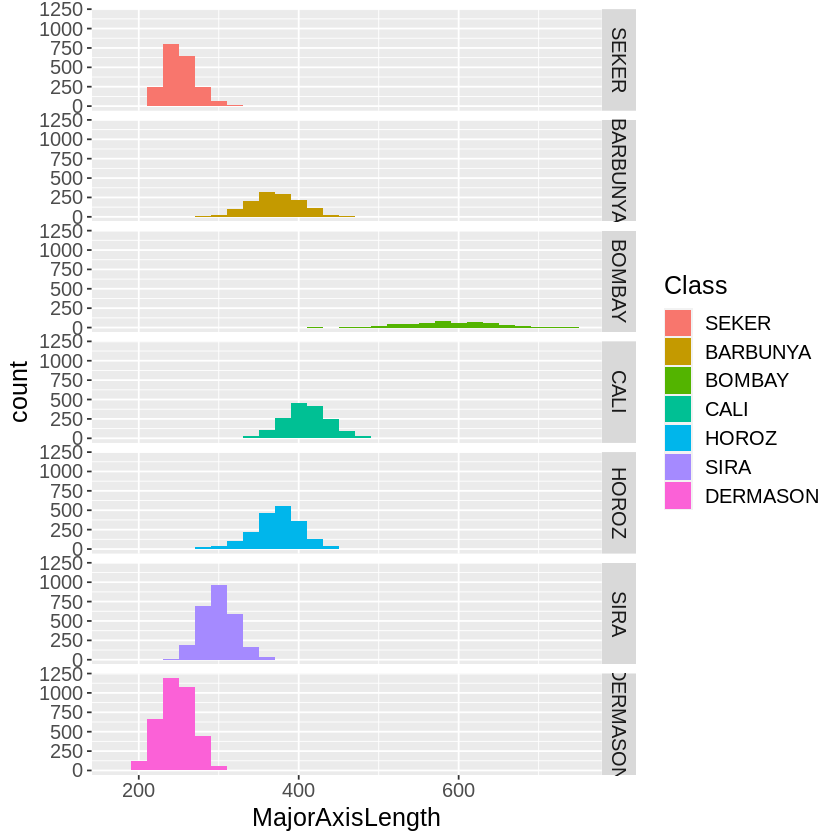

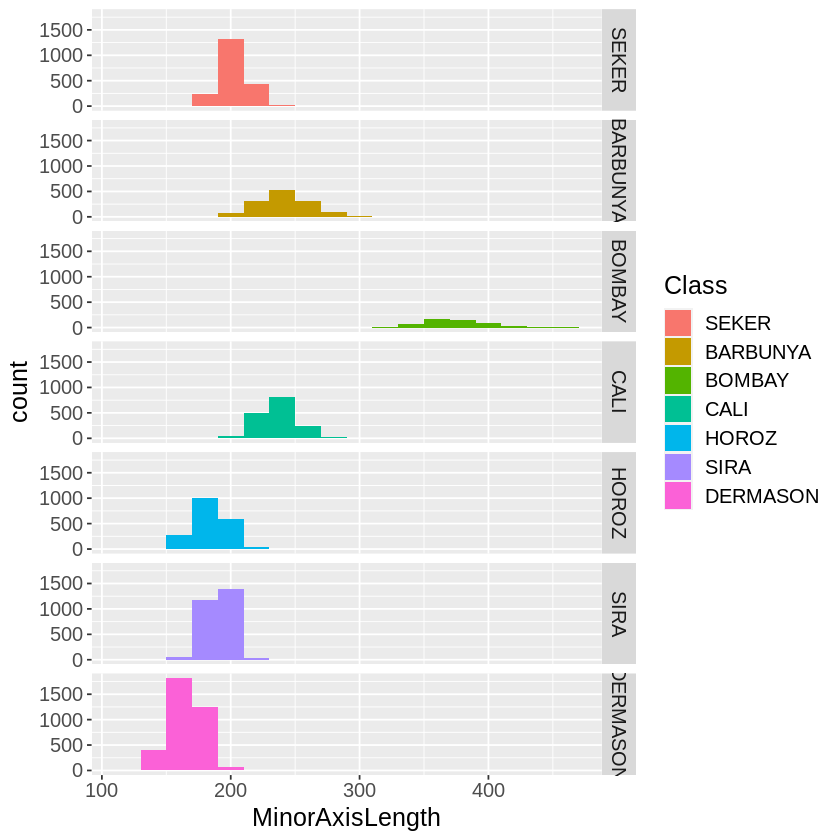

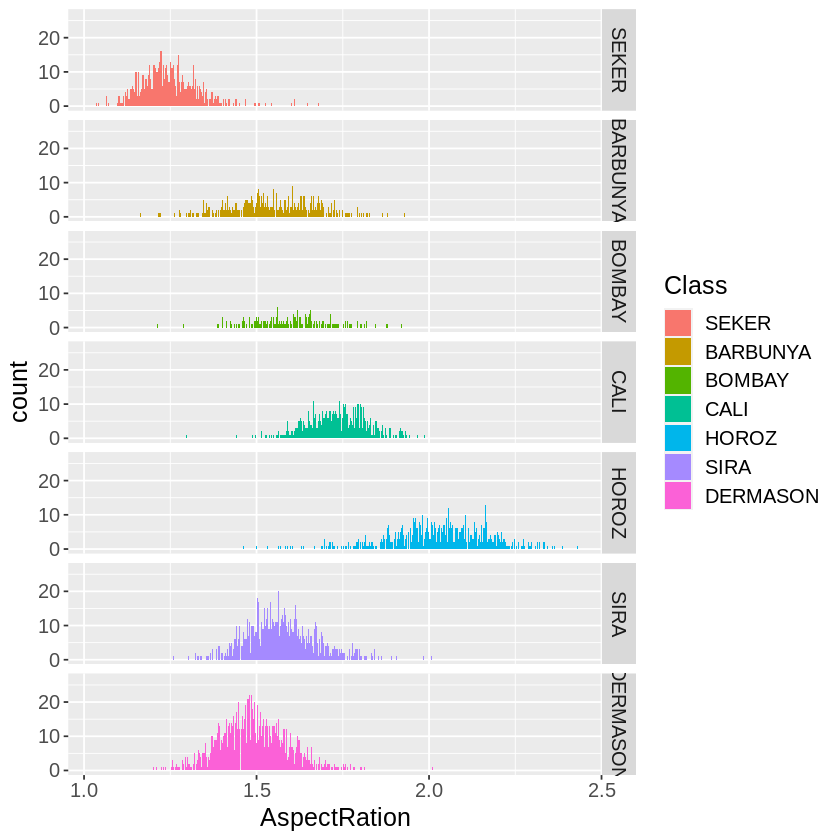

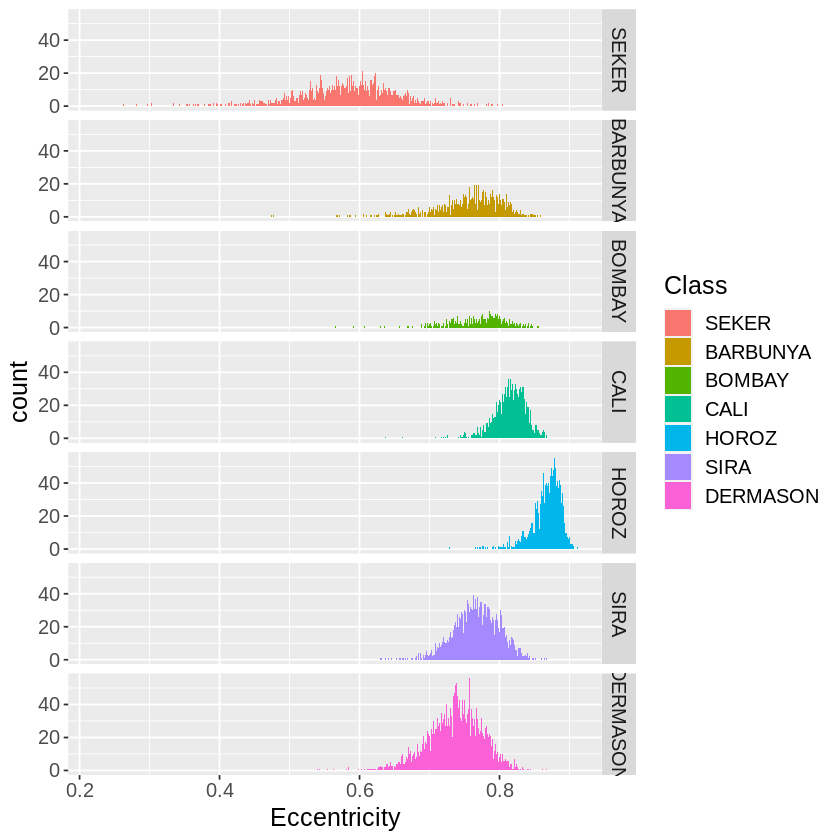

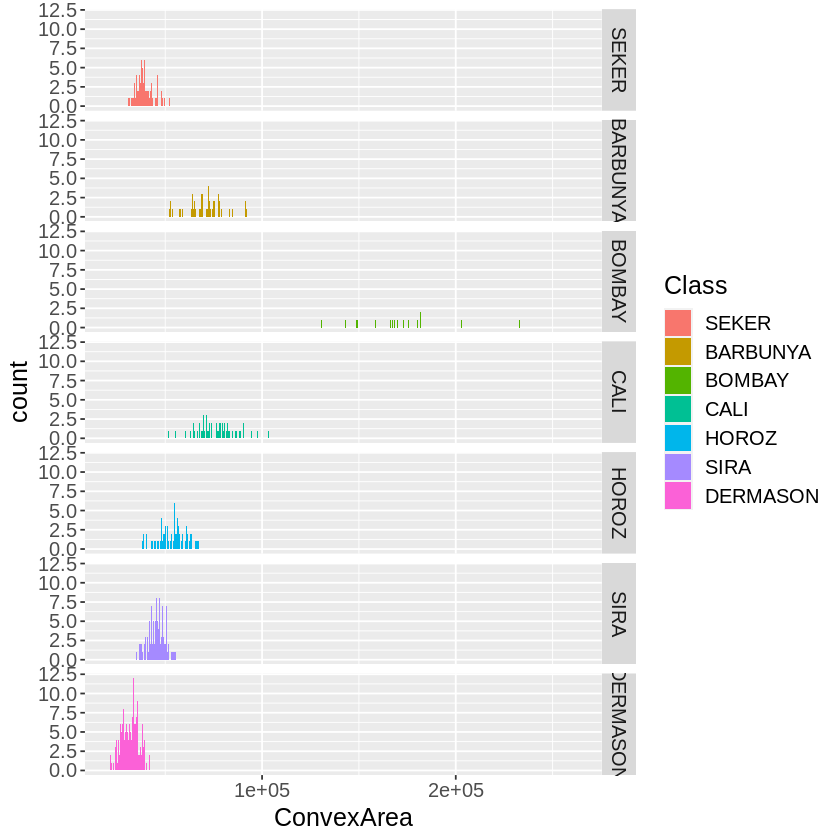

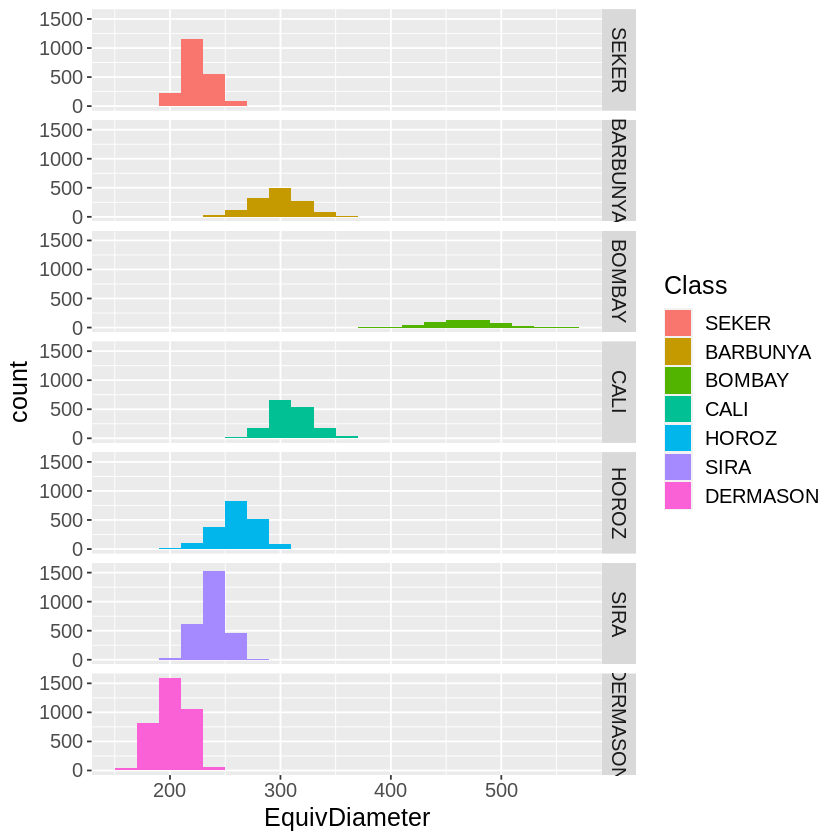

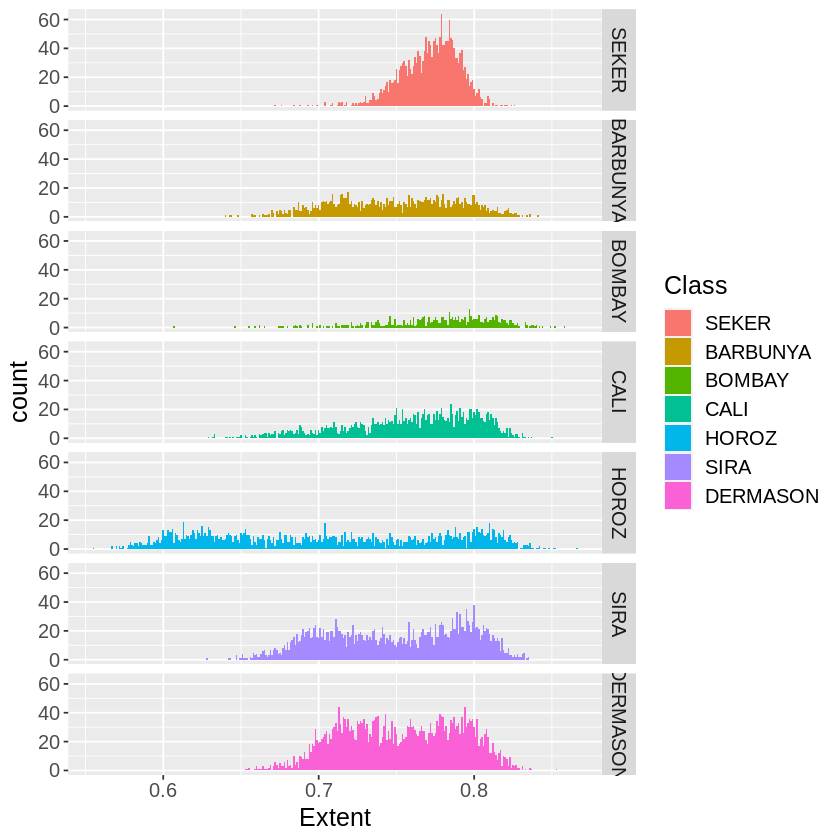

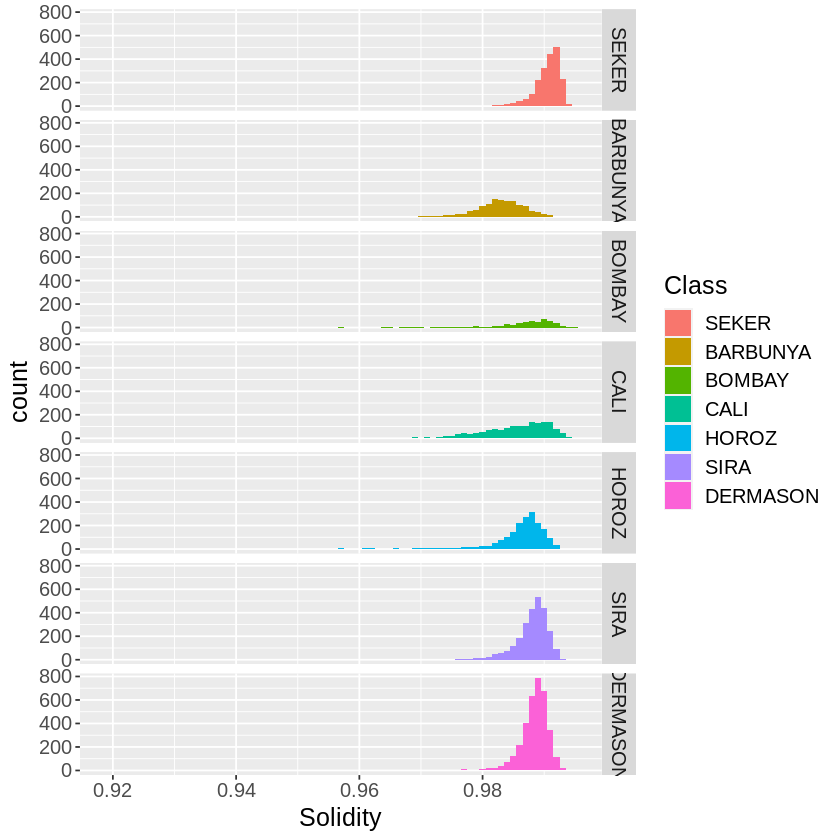

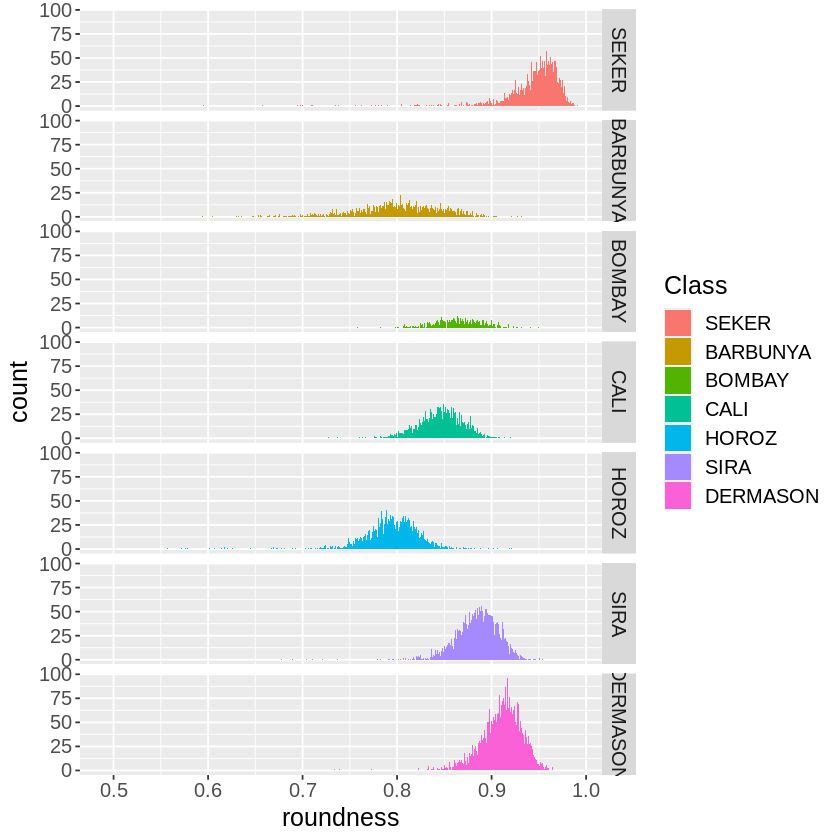

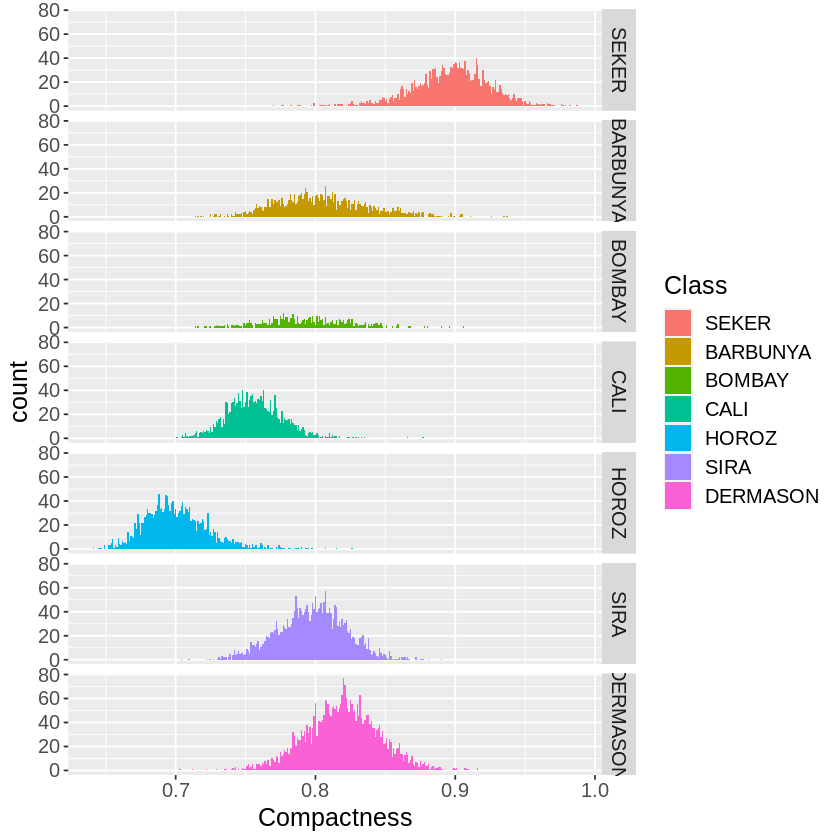

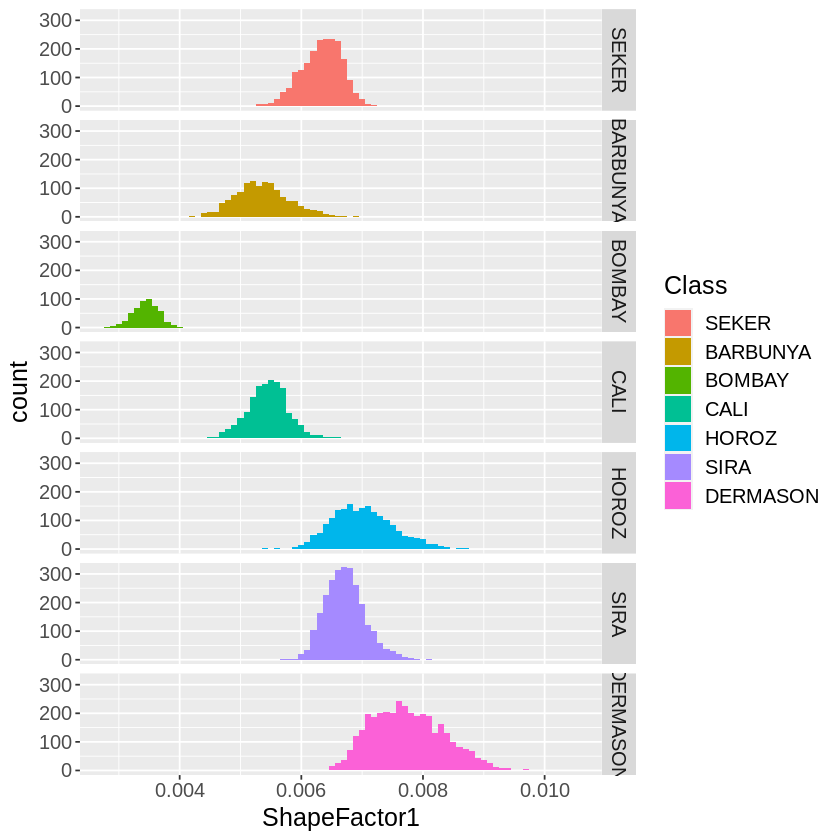

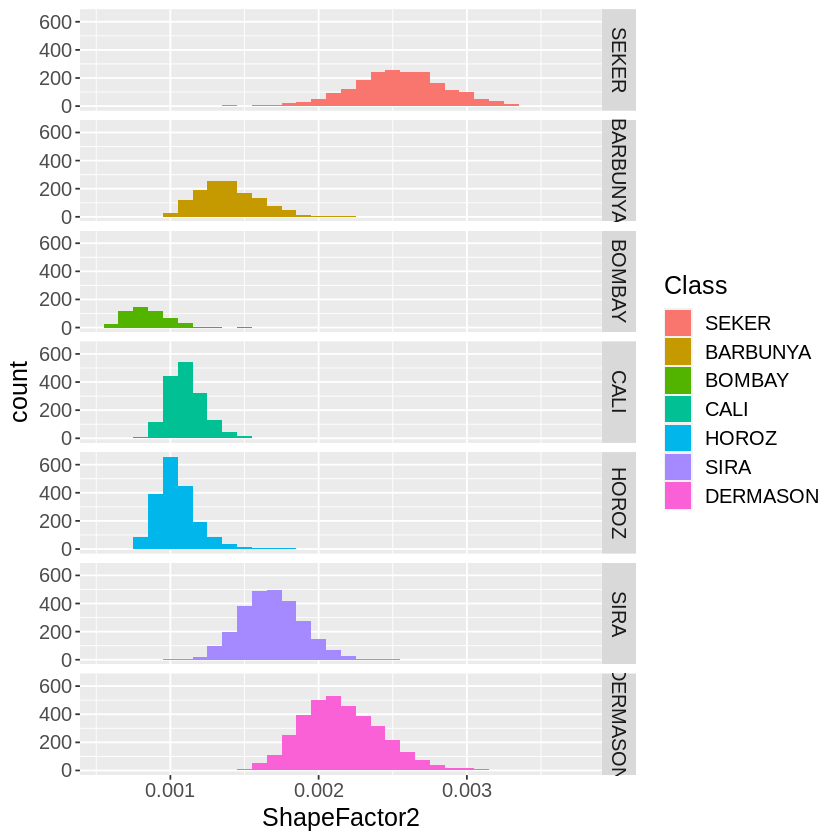

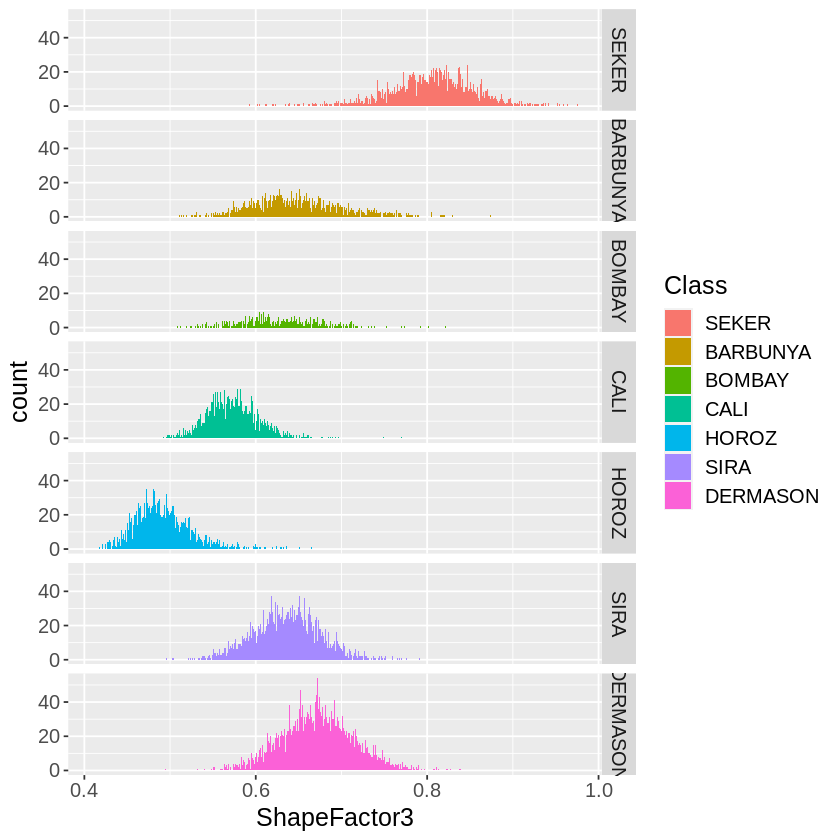

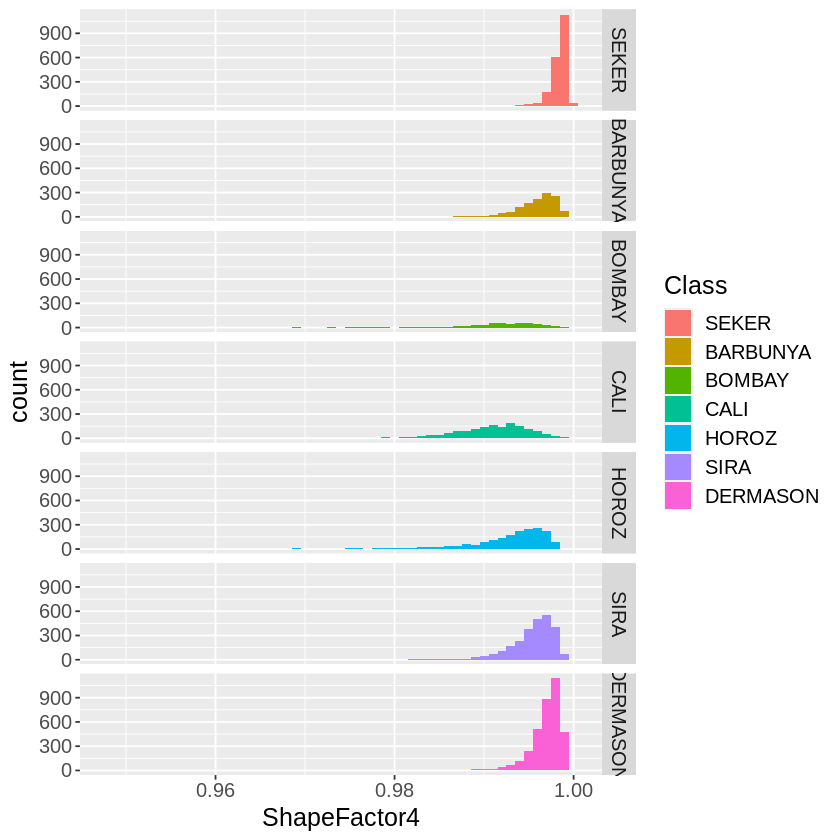

In [10]:
viz_16 <- bean_data |> 
        ggplot(aes(x= ShapeFactor4, fill = Class))+
        geom_histogram(position= "identity", binwidth = 0.001)+
        facet_grid(rows = vars(Class))+
     theme(text = element_text(size = 15))
        
viz_1 <- bean_data |> 
        ggplot(aes(x= Area, fill = Class))+
        geom_histogram(position= "identity", binwidth = 20)+
        facet_grid(rows = vars(Class))+
     theme(text = element_text(size = 15))
viz_2 <- bean_data |> 
        ggplot(aes(x= Perimeter, fill = Class))+
        geom_histogram(position= "identity", binwidth = 20)+
        facet_grid(rows = vars(Class))+
     theme(text = element_text(size = 15))
viz_3 <- bean_data |> 
        ggplot(aes(x= MajorAxisLength, fill = Class))+
        geom_histogram(position= "identity", binwidth = 20)+
        facet_grid(rows = vars(Class))+
     theme(text = element_text(size = 15))
viz_4 <- bean_data |> 
        ggplot(aes(x= MinorAxisLength, fill = Class))+
        geom_histogram(position= "identity", binwidth = 20)+
        facet_grid(rows = vars(Class))+
     theme(text = element_text(size = 15))
viz_5 <- bean_data |> 
        ggplot(aes(x= AspectRation, fill = Class))+
        geom_histogram(position= "identity", binwidth = 0.001)+
        facet_grid(rows = vars(Class))+
     theme(text = element_text(size = 15))
viz_6 <- bean_data |> 
        ggplot(aes(x= Eccentricity, fill = Class))+
        geom_histogram(position= "identity", binwidth = 0.001)+
        facet_grid(rows = vars(Class))+
     theme(text = element_text(size = 15))
viz_7 <- bean_data |> 
        ggplot(aes(x= ConvexArea, fill = Class))+
        geom_histogram(position= "identity", binwidth = 20)+
        facet_grid(rows = vars(Class))+
     theme(text = element_text(size = 15))
viz_8 <- bean_data |> 
        ggplot(aes(x= EquivDiameter, fill = Class))+
        geom_histogram(position= "identity", binwidth = 20)+
        facet_grid(rows = vars(Class))+
     theme(text = element_text(size = 15))
viz_9 <- bean_data |> 
        ggplot(aes(x= Extent, fill = Class))+
        geom_histogram(position= "identity", binwidth = 0.001)+
        facet_grid(rows = vars(Class))+
     theme(text = element_text(size = 15))
viz_10 <- bean_data |> 
        ggplot(aes(x= Solidity, fill = Class))+
        geom_histogram(position= "identity",binwidth = 0.001)+
        facet_grid(rows = vars(Class))+
     theme(text = element_text(size = 15))
viz_11 <- bean_data |> 
        ggplot(aes(x= roundness, fill = Class))+
        geom_histogram(position= "identity", binwidth = 0.001)+
        facet_grid(rows = vars(Class))+
     theme(text = element_text(size = 15))
viz_12 <- bean_data |> 
        ggplot(aes(x= Compactness, fill = Class))+
        geom_histogram(position= "identity", binwidth = 0.001)+
        facet_grid(rows = vars(Class))+
     theme(text = element_text(size = 15))
viz_13 <- bean_data |> 
        ggplot(aes(x= ShapeFactor1, fill = Class))+
        geom_histogram(position= "identity", binwidth = 0.0001)+
        facet_grid(rows = vars(Class))+
     theme(text = element_text(size = 15))
viz_14 <- bean_data |> 
        ggplot(aes(x= ShapeFactor2, fill = Class))+
        geom_histogram(position= "identity", binwidth = 0.0001)+
        facet_grid(rows = vars(Class))+
     theme(text = element_text(size = 15))
viz_15 <- bean_data |> 
        ggplot(aes(x= ShapeFactor3, fill = Class))+
        geom_histogram(position= "identity", binwidth = 0.001)+
        facet_grid(rows = vars(Class))+
     theme(text = element_text(size = 15))

viz_1
viz_2 
viz_3
viz_4
viz_5
viz_6
viz_7
viz_8
viz_9
viz_10
viz_11
viz_12
viz_13 
viz_14
viz_15
viz_16

# We also specify position = "identity" in geom_histogram to ensure the histograms for each experiment will be
# overlaid side-by-side, instead of stacked bars